# 04 - Final Forecast & Visualization

This notebook generates the 12-month revenue forecast for 2024 and creates the final visualizations.

**Output**: `outputs/figures/revenue_forecast.png`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

## 1. Load Data and Train Final Model

In [2]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_revenue_data.csv', parse_dates=['date'])

print(f"Historical data: {len(df)} months")
print(f"Date range: {df['date'].min().strftime('%Y-%m')} to {df['date'].max().strftime('%Y-%m')}")
print(f"Average monthly revenue: ${df['final_revenue'].mean():,.2f}")

Historical data: 34 months
Date range: 2021-01 to 2023-10
Average monthly revenue: $117,610.03


In [3]:
# Prepare data for Prophet
df_prophet = df[['date', 'final_revenue']].copy()
df_prophet.columns = ['ds', 'y']

# Train final Prophet model on all data
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95,
    changepoint_prior_scale=0.05  # More conservative to avoid overfitting
)

model.fit(df_prophet)
print("Final Prophet model trained!")

20:33:34 - cmdstanpy - INFO - Chain [1] start processing


20:33:34 - cmdstanpy - INFO - Chain [1] done processing


Final Prophet model trained!


## 2. Generate 12-Month Forecast

In [4]:
# Create future dataframe for 12 months
future = model.make_future_dataframe(periods=12, freq='MS')  # MS = Month Start
print(f"Future dates: {future['ds'].min()} to {future['ds'].max()}")
print(f"Total periods: {len(future)} ({len(df)} historical + 12 forecast)")

Future dates: 2021-01-01 00:00:00 to 2024-10-01 00:00:00
Total periods: 46 (34 historical + 12 forecast)


In [5]:
# Generate forecast
forecast = model.predict(future)

# View forecast for 2024
forecast_2024 = forecast[forecast['ds'] >= '2024-01-01'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_2024.columns = ['Date', 'Predicted Revenue', 'Lower Bound (95%)', 'Upper Bound (95%)']
forecast_2024['Date'] = forecast_2024['Date'].dt.strftime('%Y-%m')

print("\n=== 12-Month Revenue Forecast (2024) ===")
print(forecast_2024.to_string(index=False))

print(f"\n2024 Total Projected Revenue: ${forecast_2024['Predicted Revenue'].sum():,.2f}")
print(f"2024 Average Monthly Revenue: ${forecast_2024['Predicted Revenue'].mean():,.2f}")


=== 12-Month Revenue Forecast (2024) ===
   Date  Predicted Revenue  Lower Bound (95%)  Upper Bound (95%)
2024-01      161309.477628      144297.824384      178346.081051
2024-02      128215.648556      111033.443986      145563.088814
2024-03      106397.321189       89611.413807      122917.588392
2024-04      119287.057728      102805.321971      136261.103156
2024-05      115868.171215       98861.317381      131486.836508
2024-06      162501.427524      146223.907330      178970.582567
2024-07       95694.151699       79320.807248      113254.854447
2024-08      139232.197758      123505.218459      154593.934102
2024-09      132285.205588      115336.306438      148994.578035
2024-10      172211.819491      157167.177060      188669.886159

2024 Total Projected Revenue: $1,333,002.48
2024 Average Monthly Revenue: $133,300.25


## 3. Main Forecast Visualization

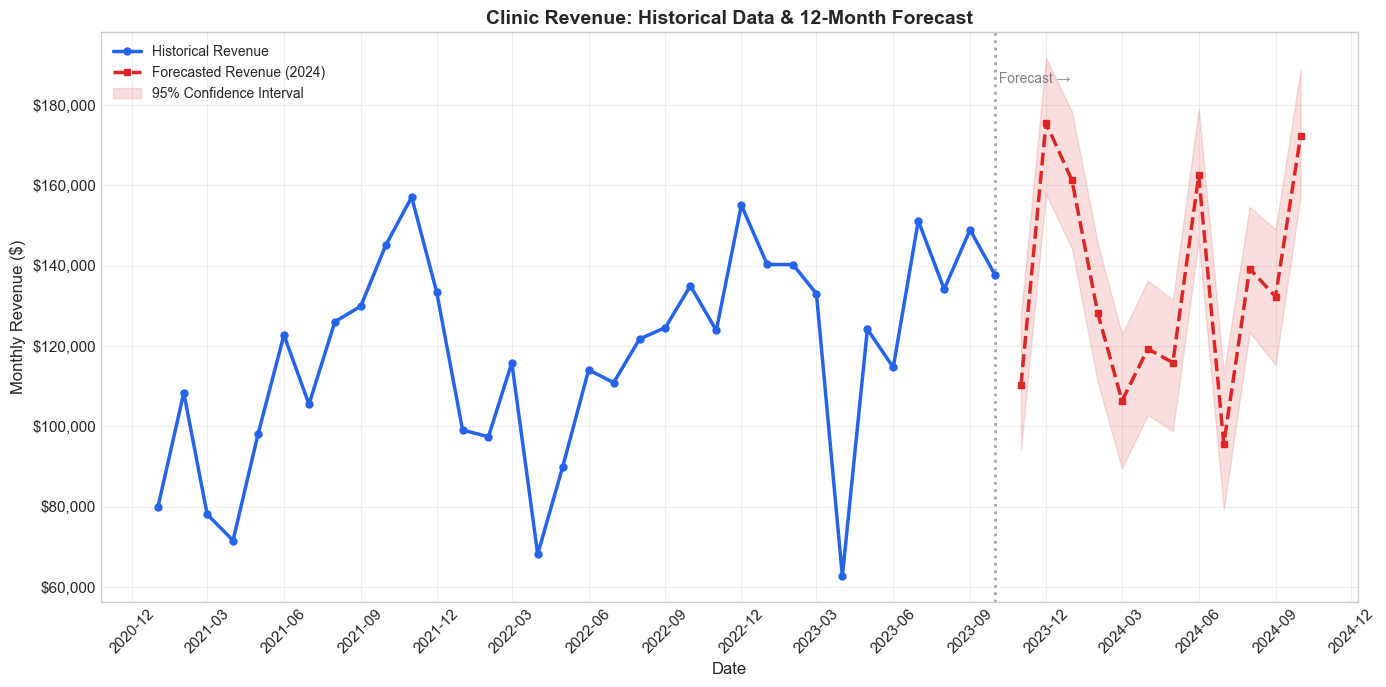


Saved: ../outputs/figures/revenue_forecast.png


In [6]:
# Create the main forecast chart
fig, ax = plt.subplots(figsize=(14, 7))

# Split data into historical and forecast
historical = forecast[forecast['ds'] <= df['date'].max()]
future_forecast = forecast[forecast['ds'] > df['date'].max()]

# Plot historical actual data (blue solid line)
ax.plot(df['date'], df['final_revenue'], 
        color='#2563eb', linewidth=2.5, marker='o', markersize=5,
        label='Historical Revenue', zorder=5)

# Plot forecast (red dashed line)
ax.plot(future_forecast['ds'], future_forecast['yhat'], 
        color='#dc2626', linewidth=2.5, linestyle='--', marker='s', markersize=5,
        label='Forecasted Revenue (2024)', zorder=5)

# Plot confidence interval (shaded area)
ax.fill_between(future_forecast['ds'], 
                future_forecast['yhat_lower'], 
                future_forecast['yhat_upper'],
                color='#dc2626', alpha=0.15, 
                label='95% Confidence Interval')

# Add vertical line separating history from forecast
ax.axvline(x=df['date'].max(), color='gray', linestyle=':', linewidth=2, alpha=0.7)
ax.text(df['date'].max(), ax.get_ylim()[1] * 0.95, ' Forecast →', 
        fontsize=10, color='gray', va='top')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Monthly Revenue ($)', fontsize=12)
ax.set_title('Clinic Revenue: Historical Data & 12-Month Forecast', fontsize=14, fontweight='bold')

# Format y-axis with dollar signs
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Format x-axis dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Add legend
ax.legend(loc='upper left', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

# Tight layout and save
plt.tight_layout()

# Save the figure
output_path = Path('../outputs/figures/revenue_forecast.png')
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')

plt.show()
print(f"\nSaved: {output_path}")

## 4. Seasonality Analysis

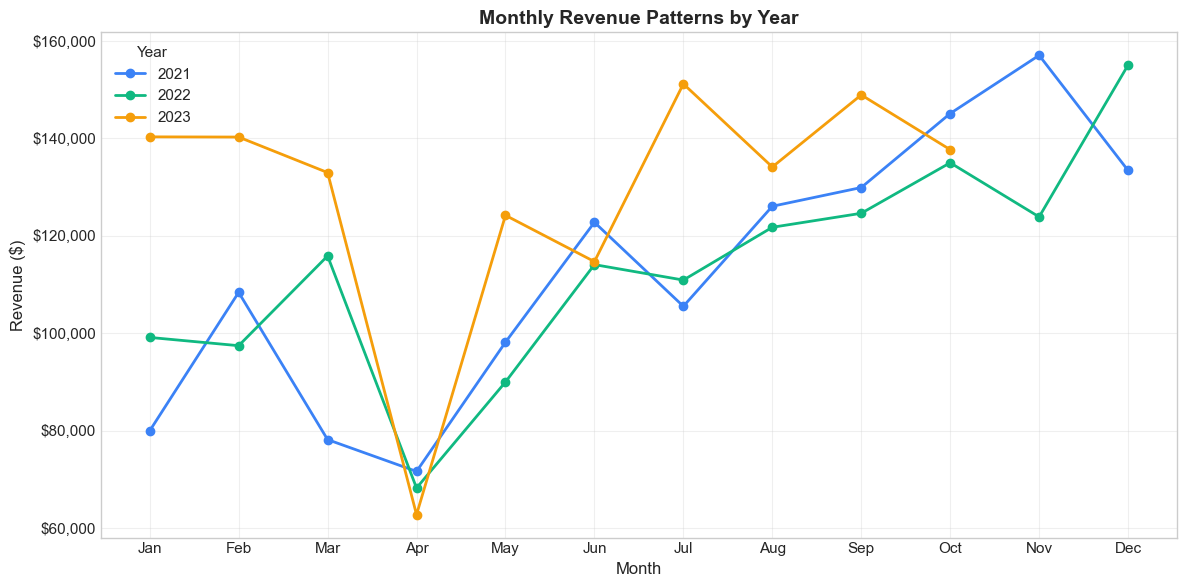

Saved: outputs/figures/seasonality_pattern.png


In [7]:
# Monthly revenue by year
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot data for comparison
df['month_name'] = df['date'].dt.strftime('%b')
monthly_by_year = df.pivot_table(values='final_revenue', index='month', columns='year', aggfunc='mean')

# Plot each year
colors = {'2021': '#3b82f6', '2022': '#10b981', '2023': '#f59e0b'}
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for year in monthly_by_year.columns:
    ax.plot(monthly_by_year.index, monthly_by_year[year], 
            marker='o', linewidth=2, label=str(year), color=colors.get(str(year), 'gray'))

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Revenue ($)', fontsize=12)
ax.set_title('Monthly Revenue Patterns by Year', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.legend(title='Year')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/seasonality_pattern.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/figures/seasonality_pattern.png")

## 5. Prophet Component Decomposition

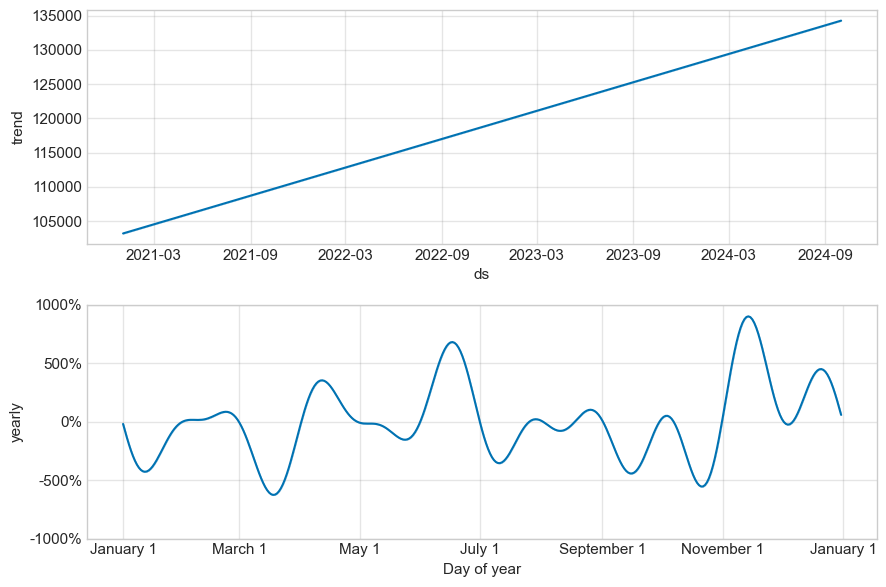

Saved: outputs/figures/prophet_components.png


In [8]:
# Prophet's built-in component plot
fig = model.plot_components(forecast)
plt.tight_layout()
plt.savefig('../outputs/figures/prophet_components.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/figures/prophet_components.png")

## 6. Revenue Breakdown by Department

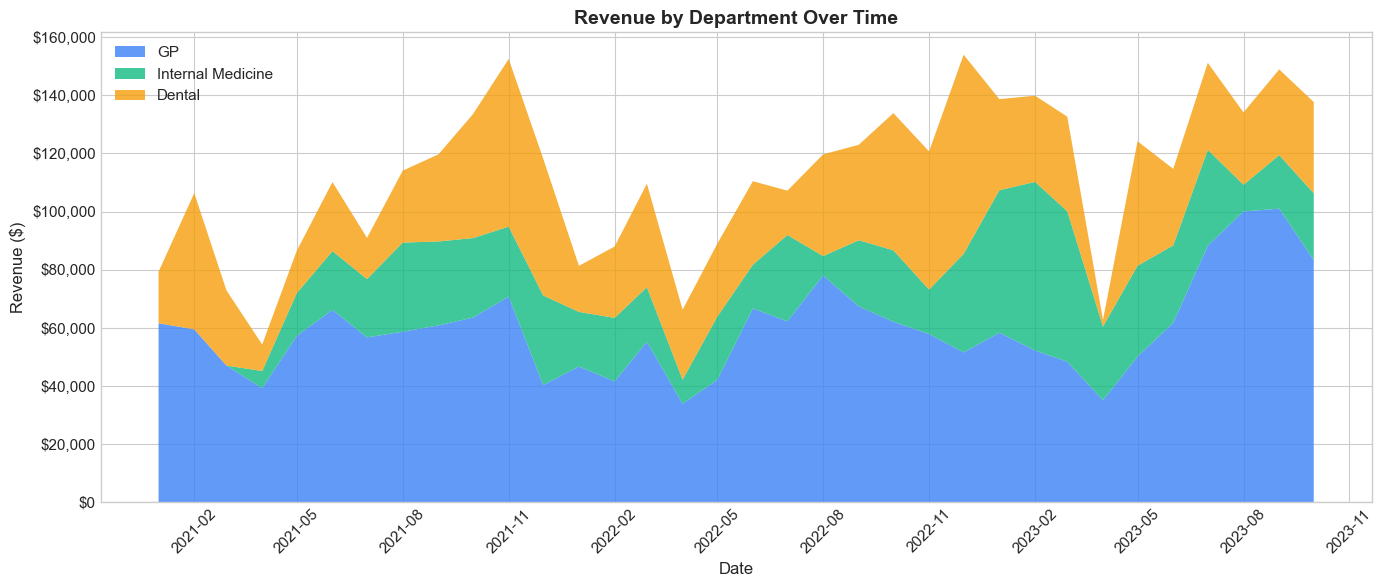

Saved: outputs/figures/department_revenue.png


In [9]:
# Department revenue over time
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate department revenues
df['gp_revenue'] = df['gp_insurance'] + df['gp_cash']
df['im_revenue'] = df['im_insurance'] + df['im_cash']
df['dental_revenue'] = df['dental_insurance'] + df['dental_cash']

# Stacked area chart
ax.stackplot(df['date'], 
             df['gp_revenue'], df['im_revenue'], df['dental_revenue'],
             labels=['GP', 'Internal Medicine', 'Dental'],
             colors=['#3b82f6', '#10b981', '#f59e0b'],
             alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Revenue ($)', fontsize=12)
ax.set_title('Revenue by Department Over Time', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/department_revenue.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/figures/department_revenue.png")

## 7. Summary Statistics

In [10]:
# Final summary
print("="*60)
print("CLINIC REVENUE FORECAST SUMMARY")
print("="*60)

print("\n📊 HISTORICAL DATA (2021-2023)")
print(f"   Total months analyzed: {len(df)}")
print(f"   Total revenue: ${df['final_revenue'].sum():,.2f}")
print(f"   Average monthly: ${df['final_revenue'].mean():,.2f}")
print(f"   Best month: ${df['final_revenue'].max():,.2f}")
print(f"   Lowest month: ${df['final_revenue'].min():,.2f}")

print("\n📈 2024 FORECAST")
forecast_values = forecast[forecast['ds'] >= '2024-01-01']['yhat']
print(f"   Predicted total: ${forecast_values.sum():,.2f}")
print(f"   Predicted monthly avg: ${forecast_values.mean():,.2f}")
print(f"   Best month forecast: ${forecast_values.max():,.2f}")
print(f"   Lowest month forecast: ${forecast_values.min():,.2f}")

print("\n📉 YEAR-OVER-YEAR GROWTH")
revenue_2021 = df[df['year'] == 2021]['final_revenue'].sum()
revenue_2022 = df[df['year'] == 2022]['final_revenue'].sum()
revenue_2023 = df[df['year'] == 2023]['final_revenue'].sum()  # Partial year

print(f"   2021 Total: ${revenue_2021:,.2f}")
print(f"   2022 Total: ${revenue_2022:,.2f} ({((revenue_2022/revenue_2021)-1)*100:+.1f}%)")
print(f"   2023 (Jan-Oct): ${revenue_2023:,.2f}")

print("\n✅ OUTPUT FILES CREATED:")
print("   • outputs/figures/revenue_forecast.png (main visualization)")
print("   • outputs/figures/seasonality_pattern.png")
print("   • outputs/figures/prophet_components.png")
print("   • outputs/figures/department_revenue.png")

CLINIC REVENUE FORECAST SUMMARY

📊 HISTORICAL DATA (2021-2023)
   Total months analyzed: 34
   Total revenue: $3,998,741.14
   Average monthly: $117,610.03
   Best month: $157,051.49
   Lowest month: $62,729.86

📈 2024 FORECAST
   Predicted total: $1,333,002.48
   Predicted monthly avg: $133,300.25
   Best month forecast: $172,211.82
   Lowest month forecast: $95,694.15

📉 YEAR-OVER-YEAR GROWTH
   2021 Total: $1,355,948.41
   2022 Total: $1,355,760.61 (-0.0%)
   2023 (Jan-Oct): $1,287,032.12

✅ OUTPUT FILES CREATED:
   • outputs/figures/revenue_forecast.png (main visualization)
   • outputs/figures/seasonality_pattern.png
   • outputs/figures/prophet_components.png
   • outputs/figures/department_revenue.png


In [11]:
# Save forecast to CSV
forecast_export = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export.columns = ['date', 'predicted_revenue', 'lower_bound_95', 'upper_bound_95']
forecast_export.to_csv('../outputs/forecast_results.csv', index=False)
print("Forecast results saved to: outputs/forecast_results.csv")

Forecast results saved to: outputs/forecast_results.csv
